# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")


## test the LightGlue class  dd

/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/stereo_matching_lightglue/LightGlue


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /Users/benmartin/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 11.4MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /Users/benmartin/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:04<00:00, 11.5MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
#/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/chromis/extract_attack_clips.ipynb
video_path = "/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/LoomExp2022/short_videos/15_cam12_stacked_short_20_240.mp4"

# read video
import cv2
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"fps: {fps}, n_frames: {n_frames}, frame_width: {frame_width}, frame_height: {frame_height}")

# read first frame
#ret, frame = cap.read()
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# read frame at frame 100
cap.set(cv2.CAP_PROP_POS_FRAMES, 100)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#split frame in half (left and right)
frame_left = frame[:, :frame_width//2]
frame_right = frame[:, frame_width//2:]

cv2.imwrite("frame_left.png", cv2.cvtColor(frame_left, cv2.COLOR_RGB2BGR))
cv2.imwrite("frame_right.png", cv2.cvtColor(frame_right, cv2.COLOR_RGB2BGR))

fps: 239.76, n_frames: 260, frame_width: 3840, frame_height: 1080


True

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

In [5]:
!pip install ultralytics
from IPython import display
display.clear_output()

from ultralytics import YOLO

In [20]:
#model = YOLO('/content/drive/My Drive/Projects/LoomExp2022/best_chromis_far.pt')
model = YOLO('/Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com//My Drive/Projects/LoomExp2022/best_chromis_far.pt')

results_left = model.predict(source = "frame_left.png")
results_right = model.predict(source = "frame_right.png")



image 1/1 /Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/stereo_matching_lightglue/LightGlue/frame_left.png: 1088x1920 8 0s, 1813.6ms
Speed: 16.1ms preprocess, 1813.6ms inference, 2.6ms postprocess per image at shape (1, 3, 1088, 1920)

image 1/1 /Users/benmartin/Library/CloudStorage/GoogleDrive-btmarti25@gmail.com/My Drive/Projects/stereo_matching_lightglue/LightGlue/frame_right.png: 1088x1920 9 0s, 1690.9ms
Speed: 7.5ms preprocess, 1690.9ms inference, 5.1ms postprocess per image at shape (1, 3, 1088, 1920)


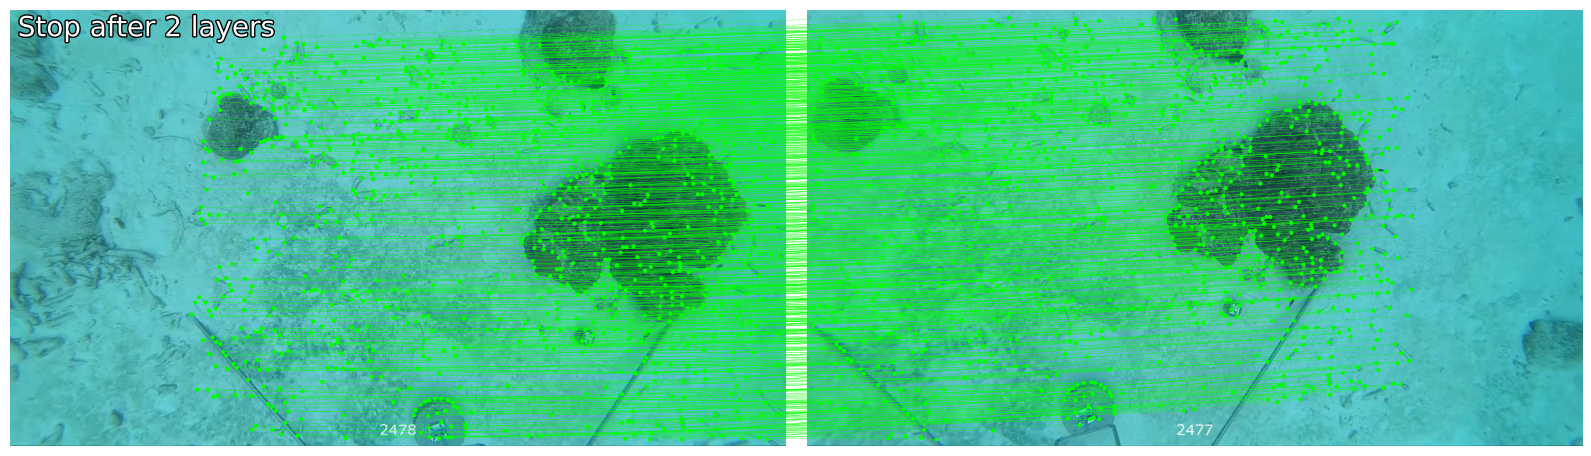

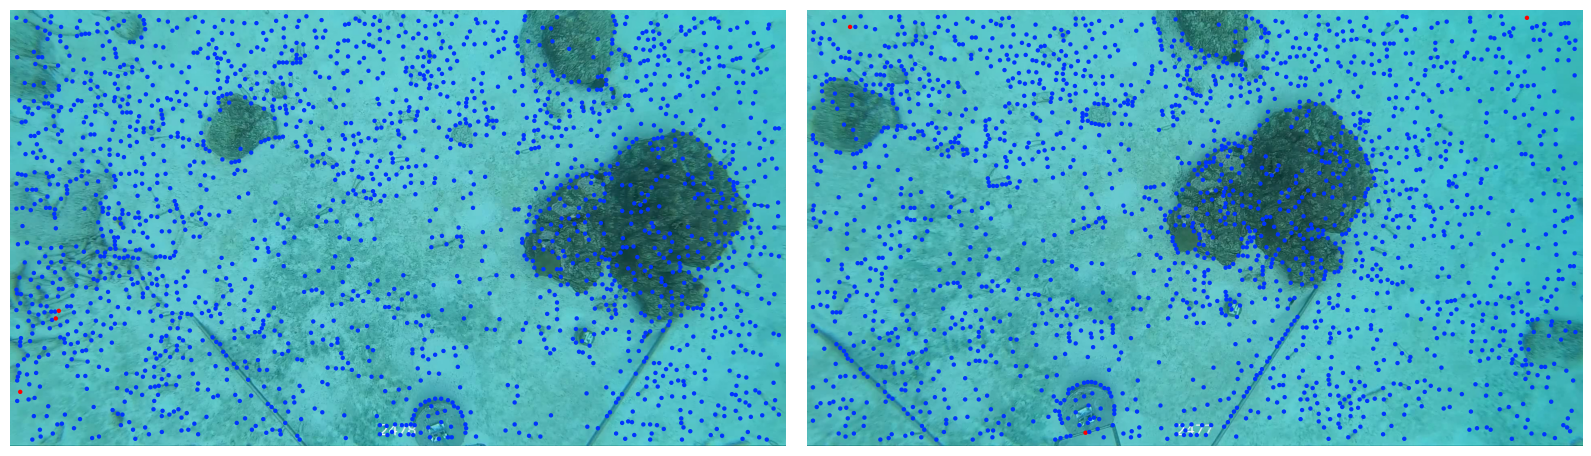

In [21]:


image0 = load_image("frame_left.png") # load_image("/content/drive/MyDrive/Projects/chromis/Bommie_feeding/Deployments/17_11_2023/Calib_images/camera_0_frame_327.jpg")
image1 = load_image("frame_right.png") # load_image("/content/drive/MyDrive/Projects/chromis/Bommie_feeding/Deployments/17_11_2023/Calib_images/camera_1_frame_327.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]


In [12]:
import numpy as np

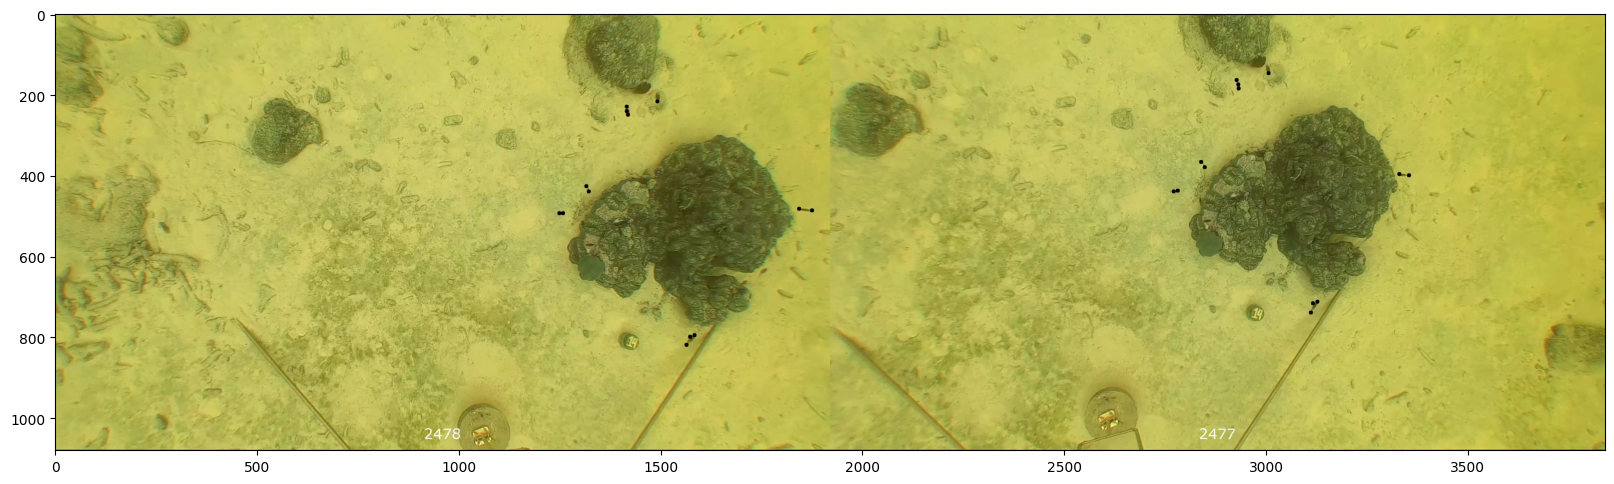

In [22]:
#get matches01 within a bounding box in the left image
#bounding box
l_x1 = results_left[0].boxes.data[:,0]
l_y1 = results_left[0].boxes.data[:,1]
l_x2 = results_left[0].boxes.data[:,2]
l_y2 = results_left[0].boxes.data[:,3]
#print(l_x, l_y, r_x, r_y)


r_x1 = results_right[0].boxes.data[:,0]
r_y1 = results_right[0].boxes.data[:,1]
r_x2 = results_right[0].boxes.data[:,2]
r_y2 = results_right[0].boxes.data[:,3]
#check which matches are within any of the bounding boxs in l_x, l_y,r_x,r_y each row represents diff bb (kpts0 is a tensor with shape (n_matches, 2))
matches_in_box_left = []
matches_in_box_left_index =[]
for i in range(len(l_x1)):
    x = l_x1[i]
    y = l_y1[i]
    w = l_x2[i] - l_x1[i]
    h = l_y2[i] - l_y1[i]
    j = 0
    for match in m_kpts0:
        if x < match[0] < x+w and y < match[1] < y+h:
            matches_in_box_left.append(match)
            matches_in_box_left_index.append(j)
        j = j + 1

matches_in_box_right = []
matches_in_box_right_index = []
for i in range(len(r_x1)):
    x = r_x1[i]
    y = r_y1[i]
    w = r_x2[i] - r_x1[i]
    h = r_y2[i] - r_y1[i]
    j = 0

    for match in m_kpts1:
        if x < match[0] < x+w and y < match[1] < y+h:
            matches_in_box_right.append(match)
            matches_in_box_right_index.append(j)
        j = j + 1    


# find the rows shared between matches_in_box_left and matches_in_box_right
shared_rows = []
for i in matches_in_box_left_index:
    if i in matches_in_box_right_index:
        shared_rows.append(i)

#plot matches_in_box_left matches_in_box_right in bounding box on the left and right imagea with opencv stack images horizontally
image0 = cv2.imread("frame_left.png")
image1 = cv2.imread("frame_right.png")

matches_left = matches[shared_rows][:,0]
matches_right = matches[shared_rows][:,1]

p_left = kpts0[matches_left]
p_right = kpts1[matches_right]

n = len(p_left)
colors = plt.cm.viridis(np.linspace(0, 1, n))
plt.figure(figsize=(20, 10))
i = 0
for match in p_left:
    cv2.circle(image0, (int(match[0]), int(match[1])), 5,  colors[i], -1)
    i = i + 1
i = 0
for match in p_right:
    cv2.circle(image1, (int(match[0]), int(match[1])), 5,  colors[i], -1)
    i = i + 1
plt.imshow(np.hstack([image0, image1]))


In [ ]:
matches_in_box_left_index[shared_rows]

TypeError: list indices must be integers or slices, not list

In [ ]:
matches[matches_in_box_left_index]

tensor([[  23,  106],
        [ 278,  197],
        [ 151,   11],
        [  36, 1970],
        [  77,   49],
        [  22,  112],
        [ 142,  622]], device='cuda:0')

In [ ]:
matches[matches_in_box_right_index]

tensor([[  23,  106],
        [  22,  112],
        [ 456, 1314],
        [ 278,  197],
        [  36, 1970],
        [  77,   49],
        [ 108,   12],
        [1688,    5],
        [  25,  373],
        [ 151,   11],
        [  72,   46]], device='cuda:0')

In [ ]:
matches = matches01['matches']

np_arr = matches.detach().cpu().numpy()
print(np_arr)

[[   0  563]
 [   1  109]
 [   2  148]
 ...
 [2039 1151]
 [2041 1611]
 [2042 1340]]


In [ ]:
print(results_right[0].boxes.data[:,0])

tensor([ 771.9641,  946.4487, 1117.7925,  961.2604, 1532.7261,  942.2261,  681.7698, 1058.0422], device='cuda:0')


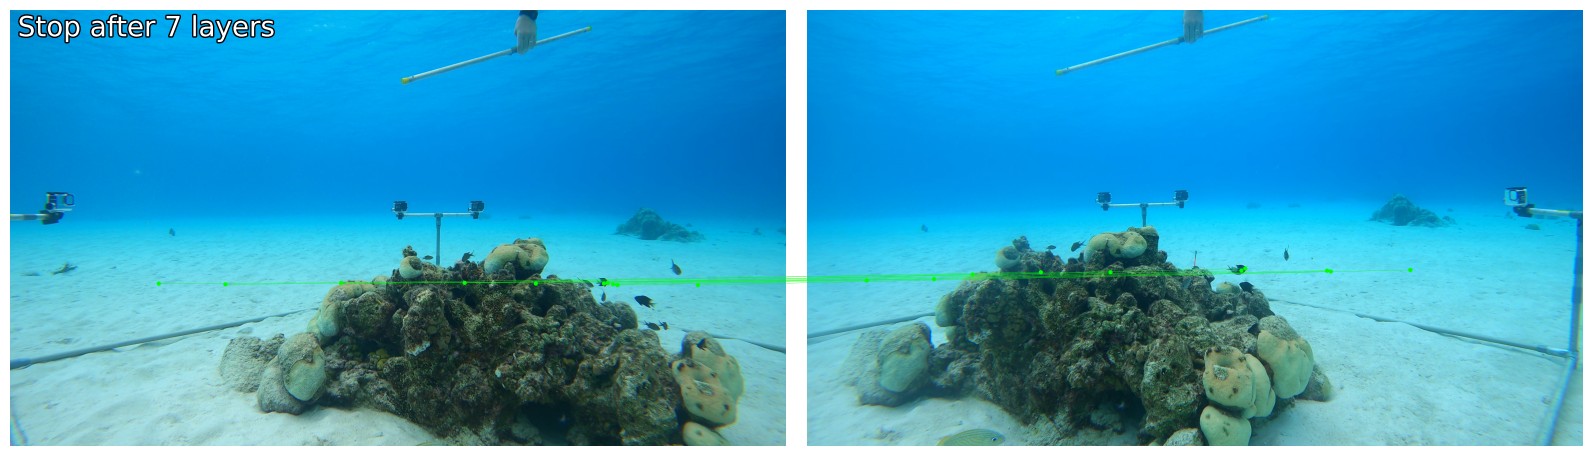

In [ ]:
axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0[200:210], m_kpts1[200:210], color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

In [ ]:
print(matches[3])

tensor([14, 10])


## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

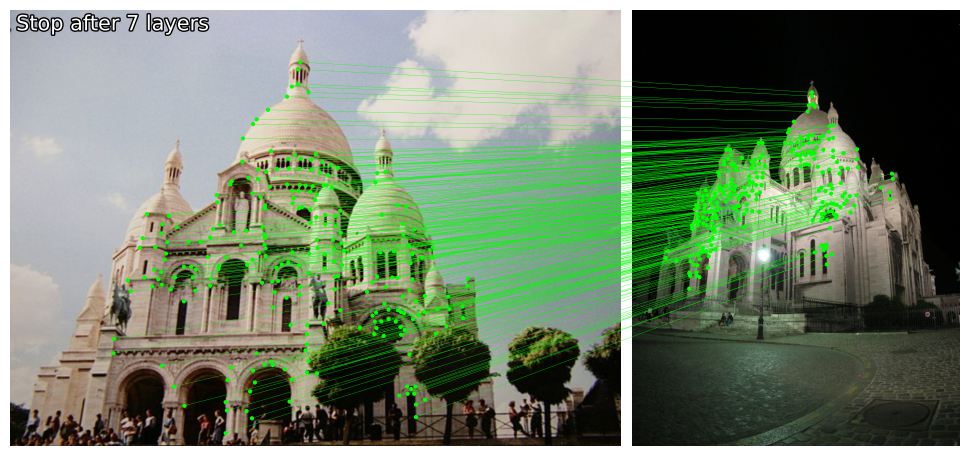

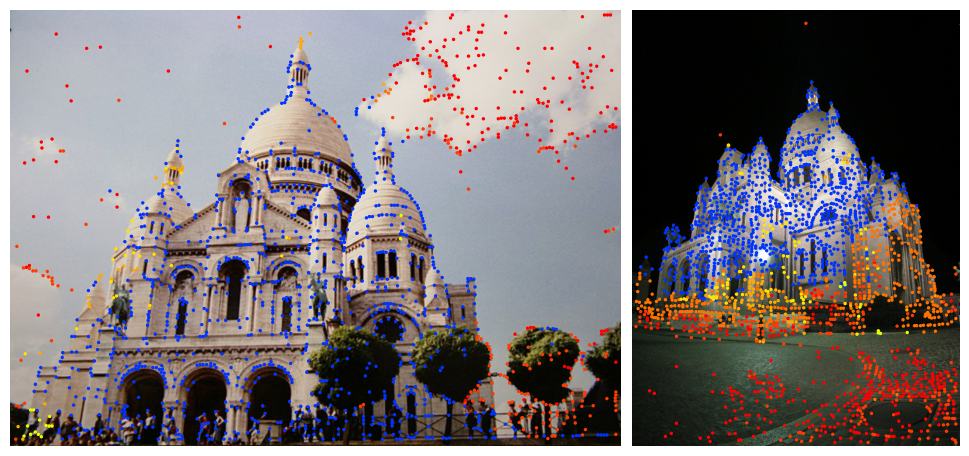

In [ ]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)